In [1]:
import os

import sqlite3
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
# Path to the root directory of datasci
dthon_path = os.path.join(os.path.expanduser('~'), 'Projects','datasci')
dthon_db = os.path.join(dthon_path, "melbourne-datathon","data","medi.db")

In [3]:
conn = sqlite3.connect(dthon_db)

# Sample SQL query to find the average prices of the drug 3028 in different regions
# Will likely have to weed out pensioner prices?

sql = """select s.postcode, p.latitude as lat, p.longitude as lon,
            round(avg(t.PatientPrice_Amt),2) as avg_patientprice,
            round(avg(t.WholeSalePrice_Amt),2) as avg_wholesaleprice,
            count(s.postcode) as samplesize-- Sample set of transactions for each suburb
        from transactions t
        join stores s on t.Store_ID = s.Store_ID
        join postcodes_geo p on s.postcode = p.postcode
        where t.Drug_ID = 3028
        --and s.postcode >= 3000
        --and s.postcode < 3500
        and t.PatientPrice_Amt > 0
        group by s.postcode
        order by avg_patientprice desc
        """

# using pandas because I like the head command
df = pd.read_sql_query(sql, conn)

In [4]:
# Might be interesting to see which stores in each suburb contributed to
# these extremes
df[['postcode','lat', 'lon']].head()

,postcode,lat,lon
0,3018,-37.87,144.83
1,7253,-41.13,146.87
2,3104,-37.79,145.07
3,2536,-35.73,150.20
4,2225,-34.00,151.09


In [6]:
# Generate co-ordinates array
xi = []
yi = []
minlat = -45;
maxlat = -10;
minlon = 110;
maxlon = 155;
for name, rows in df.iterrows():
    xi.append(rows["lon"])
    yi.append(rows["lat"])

m = Basemap(
  projection='merc',
  llcrnrlat=minlat,
  urcrnrlat=maxlat,
  llcrnrlon=minlon,
  urcrnrlon=maxlon,
  lat_ts=20,
  resolution='l'
)

m.drawcoastlines()
m.drawmapboundary()
m.drawstates()

x, y = m(xi, yi)

/opt/miniconda3/envs/dthon/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/miniconda3/envs/dthon/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


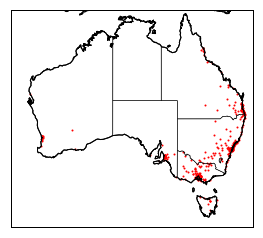

In [7]:
m.scatter(
  x,
  y,
  1,
  marker='o',
  color='red'
)

plt.show()

In [154]:
df.describe()

,lat,lon,avg_patientprice,avg_wholesaleprice,samplesize
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,-38.930000,145.590000,27.466667,10.940000,52.000000
std,1.905676,1.114989,1.706937,3.452926,32.186954
min,-41.130000,144.830000,26.210000,7.360000,16.000000
25%,-39.500000,144.950000,26.495000,9.285000,39.000000
50%,-37.870000,145.070000,26.780000,11.210000,62.000000
75%,-37.830000,145.970000,28.095000,12.730000,70.000000
max,-37.790000,146.870000,29.410000,14.250000,78.000000


In [50]:
# Now doing similar things with panda commands, simplifying SQL
# Same result == good

# In summary, acheived a little, but have had to resort to casting
# floats as floats and sql if I want to do anything like sum or mean below??
sql = """select s.postcode, t.PatientPrice_Amt, t.WholeSalePrice_Amt
        from transactions t
        join stores s on t.Store_ID = s.Store_ID
        where t.Drug_ID = 3028
        --and s.postcode >= 3000
        --and s.postcode < 3500
        and t.PatientPrice_Amt > 0
        """

dfs = pd.read_sql(sql, conn)

In [51]:
dfs.describe()

,postcode,PatientPrice_Amt,WholeSalePrice_Amt
count,10263,10263.0,10263.00
unique,531,391.0,56.00
top,7011,6.0,1.86
freq,309,1584.0,3177.00


In [87]:
aggregations = {
    'PatientPrice_Amt': {
        'Min Patient Price': 'min',
        'Max Patient Price': 'max'
    },
    'WholeSalePrice_Amt': {
        'Avg Patient Price': 'mean',
        'Max Patient Price': 'max'
    }
}

dfs.groupby('postcode').agg(aggregations)



PatientPrice_Amt                   WholeSalePrice_Amt  \
         Min Patient Price Max Patient Price  Max Patient Price   
postcode                                                          
0812                  4.75              4.75               1.12   
0820                  5.80               5.8               1.86   
2000                  5.60                16               2.70   
2006                 10.35             10.35               2.70   
2007                  7.00                 7               2.70   
2011                 14.65             14.65               2.70   
2018                  5.60               5.6               1.86   
2020                  1.96               6.2               4.66   
2021                  9.90               9.9               1.86   
2022                  5.60             13.45               4.66   
2027                  6.00                 8               1.86   
2029                  9.75              9.75               1.86   
2031                  5.60               6.1               3.72   
2040                  6.00              9.47               2.70   
2045                  5.60               5.8               1.86   
2046                  5.60                 6               2.70   
2068                  5.60               5.9               1.86   
2076                  5.60               5.9               1.86   
2077                  5.60                 6               8.11   
2084                  6.00             17.85              13.98   
2095                  5.60                 6               2.70   
2099                  9.99              9.99               1.77   
2103                  5.60              6.95               2.70   
2107                  5.60               5.8               1.86   
2112                  2.00                12               5.41   
2113                  5.60               5.9               1.86   
2115                  5.60              14.8               5.41   
2117                  5.60               6.1               2.70   
2118                  5.60             15.45               5.41   
2120                  1.96             14.35               5.41   
...                    ...               ...                ...   
6026                  5.60             17.85               1.86   
6027                  7.15             15.25               3.58   
6056                 19.95             20.95               2.70   
6057                 17.05             17.05               5.41   
6060                  6.10               6.1               5.41   
6076                  5.60              16.7               2.70   
6150                 21.20              21.2               8.11   
6154                 21.20              21.4               5.41   
6157                  5.60              24.4              10.82   
6162                 15.95                18               5.58   
6164                  5.60               5.6               1.86   
6173                  5.90               6.1               5.41   
6210                 13.58             15.98               5.41   
6230                  5.60               5.6               5.41   
6430                  5.90               6.1               5.41   
6450                 15.95             15.95               2.70   
6701                 16.95             16.95               2.70   
7000                  5.60               5.6               3.72   
7011                  1.96              8.26               4.66   
7018                  6.00                 6               6.49   
7140                  5.90               6.1               5.41   
7190                  5.60              13.6               5.41   
7216                  5.80               5.8               3.72   
7248                  6.10               6.1               5.41   
7249                  5.60             10.11               9.32   
7250                  5.60             15.69             

In [206]:
patient_id = [1,4]

SQL = """
SELECT *
FROM transactions a
LEFT OUTER JOIN ChronicIllness_LookUp b
ON a.Drug_ID = b.MasterProductID
LEFT OUTER JOIN patients c
ON a.Patient_ID = c.Patient_ID
WHERE a.Patient_ID = {}
   """.format(patient_id)

pd.read_sql_query(SQL, conn)

DatabaseError: Execution failed on sql '
SELECT *
FROM transactions a
LEFT OUTER JOIN ChronicIllness_LookUp b
ON a.Drug_ID = b.MasterProductID
LEFT OUTER JOIN patients c
ON a.Patient_ID = c.Patient_ID
WHERE a.Patient_ID = [1, 4]
   ': no such column: 1, 4